In [1]:
# --- Basic Imports ---
from utils import *

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score,
                             precision_recall_fscore_support, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, log_loss)

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from category_encoders import WOEEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import shap

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def find_best_threshold(y_true, y_prob, metric="f1"):
    thresholds = np.linspace(0.01, 0.99, 200)
    scores = []

    for t in thresholds:
        y_pred = (y_prob > t).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )

        if metric == "precision":
            scores.append(precision)
        elif metric == "recall":
            scores.append(recall)
        else:  # default f1
            scores.append(f1)

    scores = np.array(scores)
    best_idx = scores.argmax()
    best_threshold = thresholds[best_idx]
    best_score = scores[best_idx]

    return best_threshold, best_score, thresholds, scores, metric

In [3]:
# Plot Themes
ACCENT_COLOR = "#2ab7ca"
SECOND_COLOR = "#0d3b66"
HIGHLIGHT_COLOR = "#ff0000ea"

# --- Theme & custom accent color ---
sns.set_theme(style="whitegrid", palette="mako")

model_type = 'Logistic_Regression_Model'
start_date = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
path = MODEL_DIR+model_type+"_"+start_date

os.makedirs(path, exist_ok=True)

In [4]:
df = pd.read_csv(os.path.join(SILVER_PATH, 'base_dataset.csv'), sep=';')

# Feature Engineering

In [5]:
# Show job categories from dataset
job_counts = df['job'].value_counts(normalize=True)
print(job_counts)

# Map jobs to categories to reduce cardinality
job_mapping = {
    "admin.": "admin",
    "blue-collar": "blue_collar",
    "technician": "technician",
    "services": "services_group",
    "housemaid": "services_group",
    "management": "management",
    "retired": "no_labor_force",
    "student": "no_labor_force",
    "unemployed": "no_labor_force",
    "entrepreneur": "self_employed_group",
    "self-employed": "self_employed_group",
    "unknown": "unknown"
}
df['job'] = df['job'].map(job_mapping)

job
admin.           0.253036
blue-collar      0.224718
technician       0.163663
services         0.096343
management       0.071012
retired          0.041723
entrepreneur     0.035360
self-employed    0.034510
housemaid        0.025743
unemployed       0.024626
student          0.021250
unknown          0.008014
Name: proportion, dtype: float64


In [6]:
# Show education categories from dataset
education_counts = df['education'].value_counts(normalize=True)
print(education_counts)

# ------------------------------------------
# Education Simplification Mapping (Dictionary)
# ------------------------------------------
education_map = {
    "university.degree": "university_degree",
    "high.school": "high_school",
    "basic.9y": "basic_education",
    "basic.6y": "basic_education",
    "basic.4y": "basic_education",
    "illiterate": "illiterate",
    "professional.course": "professional_course",
    "unknown": "unknown"
}

# Apply mapping
df["education_simplified"] = df["education"].map(education_map).fillna("unknown")


education
university.degree      0.295415
high.school            0.231008
basic.9y               0.146809
professional.course    0.127259
basic.4y               0.101418
basic.6y               0.055639
unknown                0.042015
illiterate             0.000437
Name: proportion, dtype: float64


In [7]:
# Cyclical encoding of 'month' feature and day-of-the-week feature
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df.drop('month', axis=1, inplace=True)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df.drop('day_of_week', axis=1, inplace=True)

In [8]:
# Numeric × Numeric
df["age_emp_rate"] = df["age"] * df["emp_var_rate"]
df["cons_price_cons_conf"] = df["cons_price_idx"] * df["cons_conf_idx"]
df["euribor_nrm"] = df["euribor3m"] / (df["nr_employed"] + 1)

# Categorical × Numeric
df["job_x_age"] = df["job"].astype(str) + "_" + pd.cut(df["age"], bins=[18,30,45,60,100]).astype(str)

# Categorical × Categorical
df["job_x_marital"] = df["job"].astype(str) + "_" + df["marital"].astype(str)
df["education_x_default"] = df["education"].astype(str) + "_" + df["default"].astype(str)

# Campaign intensity
df["campaign_log"] = np.log1p(df["campaign"])
df["contacts_ratio"] = df["campaign"] / (df["pdays"] + 2)

# Volatility indicators
df["economic_volatility"] = df[["cons_price_idx","cons_conf_idx","emp_var_rate"]].std(axis=1)

# Logistic Regression

### Train Test Split

In [9]:
X = df.drop(columns=['y']).copy()
y = df['y'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### PCA on
- `emp_var_rate`  
- `euribor3m`  
- `nr_employed`  
- `cons_price_idx`  

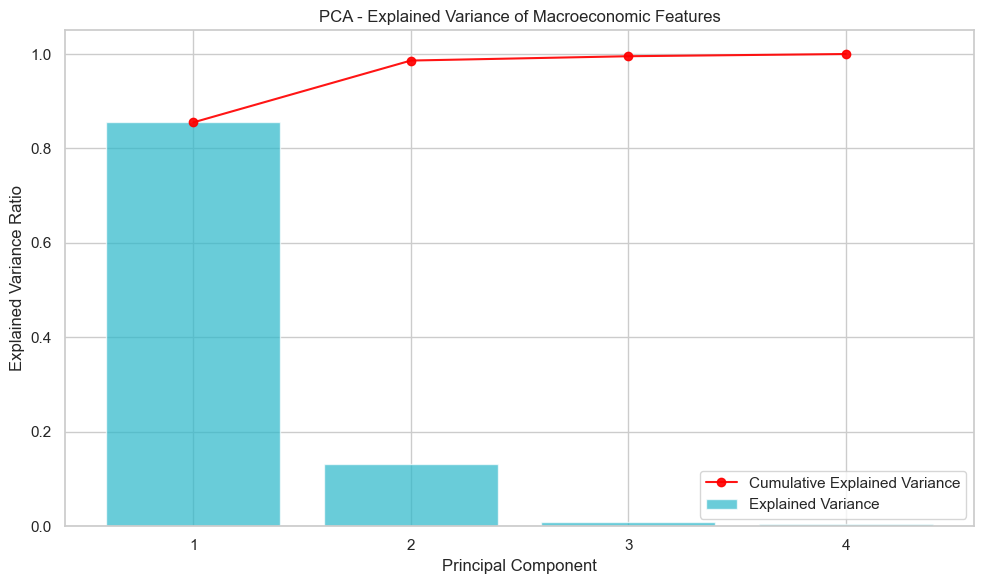

In [10]:
macro_cols = ['emp_var_rate','euribor3m','nr_employed','cons_price_idx']

# Extract macroeconomic features from training data
X_macro_train = X_train[macro_cols].copy()
X_macro_test = X_test[macro_cols].copy()

# Standardize the macroeconomic features
scaler = StandardScaler()
X_macro_train_scaled = scaler.fit_transform(X_macro_train)
X_macro_test_scaled = scaler.transform(X_macro_test)

# Apply PCA to reduce dimensions
pca = PCA()
pca.fit(X_macro_train_scaled)

# Explained variance ratios
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plot
plt.figure(figsize=(10,6))

components = np.arange(1, len(explained_var) + 1)

# Bar plot for individual component variance
plt.bar(components, explained_var, alpha=0.7, label="Explained Variance", color=ACCENT_COLOR)

# Line plot for cumulative variance
plt.plot(components, cumulative_var, marker='o', color=HIGHLIGHT_COLOR, label="Cumulative Explained Variance")

plt.xticks(components)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA - Explained Variance of Macroeconomic Features")
plt.legend()
plt.tight_layout()
plt.savefig(f"{path}/pca_explained_variance.png", dpi=300)
plt.show()

Keeping 2 principal componenets to explain more than 85% of the variance of the 4 features we will apply PCA to 1 component removing the 4 features

In [11]:
# Apply PCA to reduce dimensions
pca = PCA(n_components=2)
pca.fit(X_macro_train_scaled)

# Transform training and testing macroeconomic features
X_macro_train_pca = pca.transform(X_macro_train_scaled)
X_macro_test_pca = pca.transform(X_macro_test_scaled)

# Add PCA components back to the main datasets removing original macro features
X_train = X_train.drop(columns=macro_cols)
X_test = X_test.drop(columns=macro_cols)

X_train["macro_pca_1"] = X_macro_train_pca[:, 0]
X_train["macro_pca_2"] = X_macro_train_pca[:, 1]

X_test["macro_pca_1"] = X_macro_test_pca[:, 0]
X_test["macro_pca_2"] = X_macro_test_pca[:, 1]

### Fit pipeline

In [12]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_features, categorical_features

(['age',
  'campaign',
  'pdays',
  'previous',
  'cons_conf_idx',
  'month_sin',
  'month_cos',
  'day_of_week_sin',
  'day_of_week_cos',
  'age_emp_rate',
  'cons_price_cons_conf',
  'euribor_nrm',
  'campaign_log',
  'contacts_ratio',
  'economic_volatility',
  'macro_pca_1',
  'macro_pca_2'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'poutcome',
  'education_simplified',
  'job_x_age',
  'job_x_marital',
  'education_x_default'])

In [13]:
# Search space for hyperparameter tuning
param_grid = {
    "preprocessor__num__select__k": [3, 5, 8, 10],
    "preprocessor__cat__woe__regularization": [0.01, 0.1, 1.0, 10.0],
    "preprocessor__cat__select__k": [3, 8, 12],
    "smote__sampling_strategy": [0.5, 0.7],
    "smote__k_neighbors": [2, 3, 5, 6],
    "model__C": [0.01, 0.1, 1],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],
    "model__max_iter": [100, 500, 1000, 2000]
}

In [14]:
# Preprocessing pipelines for numeric and categorical data
numeric_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif))
])

categorical_pipeline = Pipeline(steps=[
    ("woe", WOEEncoder()),
    ("select", SelectKBest(score_func=mutual_info_classif))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
    ]
)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE()),
    ("model", LogisticRegression())
])

# Grid Search for Hyperparameter Tuning
grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=3
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best ROC AUC:", grid.best_score_)

# Replace clf with best pipeline
clf = grid.best_estimator_

Fitting 3 folds for each of 4608 candidates, totalling 13824 fits
Best parameters: {'model__C': 0.1, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'preprocessor__cat__select__k': 3, 'preprocessor__cat__woe__regularization': 10.0, 'preprocessor__num__select__k': 8, 'smote__k_neighbors': 6, 'smote__sampling_strategy': 0.5}
Best ROC AUC: 0.7788327989092916


In [15]:
# Access fitted preprocessor
pre = clf.named_steps["preprocessor"]

# Numeric features
num_pipe = pre.named_transformers_["num"]
num_selector = num_pipe.named_steps["select"]
num_mask = num_selector.get_support()
num_selected_features = np.array(numeric_features)[num_mask]

# Categorical features (WOE -> 1 col per cat feature)
cat_pipe = pre.named_transformers_["cat"]
cat_selector = cat_pipe.named_steps["select"]
cat_mask = cat_selector.get_support()

# WOEEncoder output column names = original categorical feature names
cat_selected_features = np.array(categorical_features)[cat_mask]

# Combine into final order
final_feature_names = np.concatenate([num_selected_features, cat_selected_features])

print("Final feature names used in the model:")
print(final_feature_names)
print("Feature count:", len(final_feature_names))
print("Coefficient count:", len(clf.named_steps['model'].coef_[0]))


Final feature names used in the model:
['pdays' 'previous' 'month_cos' 'age_emp_rate' 'euribor_nrm'
 'contacts_ratio' 'macro_pca_1' 'macro_pca_2' 'contact' 'poutcome'
 'job_x_age']
Feature count: 11
Coefficient count: 11


### Threshold Tunning

📌 Best threshold: 0.46306532663316585
📈 Best F1 score: 0.4830832597822889
ROC AUC: 0.7870365270787323


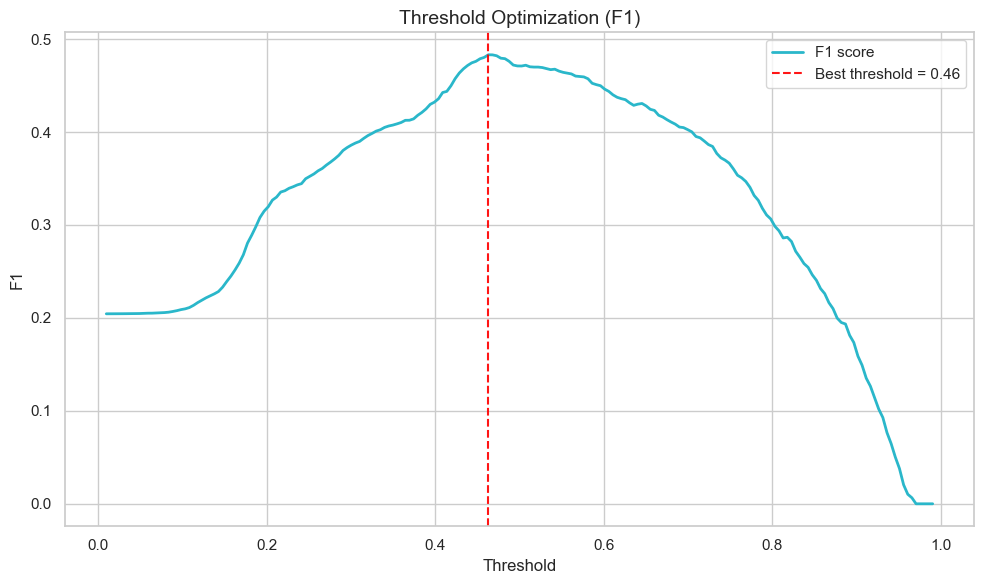


Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     12042
           1       0.44      0.53      0.48      1547

    accuracy                           0.87     13589
   macro avg       0.69      0.72      0.70     13589
weighted avg       0.88      0.87      0.88     13589

Confusion Matrix:
[[11011  1031]
 [  726   821]]


In [16]:
sns.set(style="whitegrid")

# Run optimization
y_prob = clf.predict_proba(X_test)[:, 1]

best_threshold, best_score, thresholds, scores, metric = find_best_threshold(
    y_test, y_prob, metric="f1"
)

print("📌 Best threshold:", best_threshold)
print("📈 Best F1 score:", best_score)
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Seaborn plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=scores, label=f"{metric.upper()} score", linewidth=2, color=ACCENT_COLOR)

plt.axvline(best_threshold, color=HIGHLIGHT_COLOR, linestyle='--',
            label=f"Best threshold = {best_threshold:.2f}")

plt.xlabel("Threshold", fontsize=12)
plt.ylabel(metric.upper(), fontsize=12)
plt.title(f"Threshold Optimization ({metric.upper()})", fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig(f"{path}/threshold_optimization.png", dpi=300)
plt.show()

# Apply best threshold
y_pred_opt = (y_prob > best_threshold).astype(int)

print("\nClassification Report with Best Threshold:")
print(classification_report(y_test, y_pred_opt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_opt))


### Least useful features

In [17]:
logreg = clf.named_steps["model"]
coefs = logreg.coef_[0]

feature_importance = pd.DataFrame({
    "feature": final_feature_names,
    "coefficient": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

feature_importance

# Print features with absolute coefficient less than 0.05
cols_to_drop = feature_importance[feature_importance["abs_coef"] <= 0.05]["feature"].tolist()
print(feature_importance[feature_importance["abs_coef"] <= 0.05])

     feature  coefficient  abs_coef
9   poutcome    -0.042978  0.042978
2  month_cos    -0.002816  0.002816


### SHAP

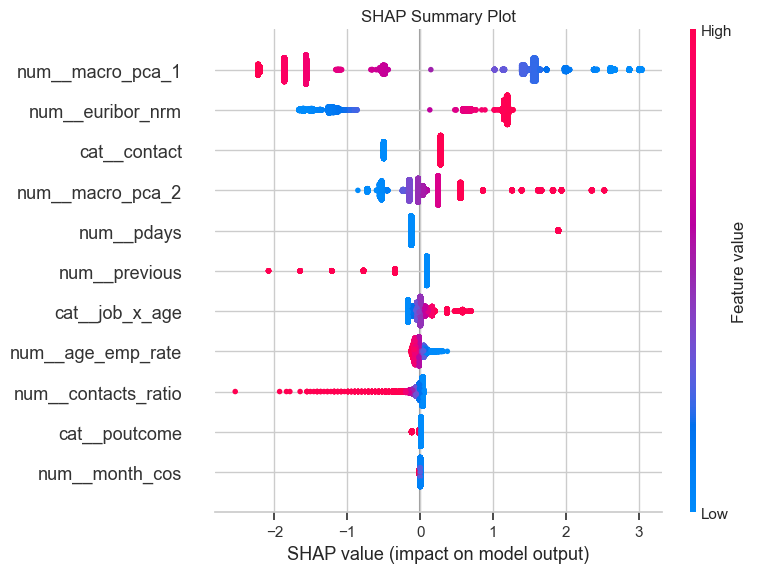

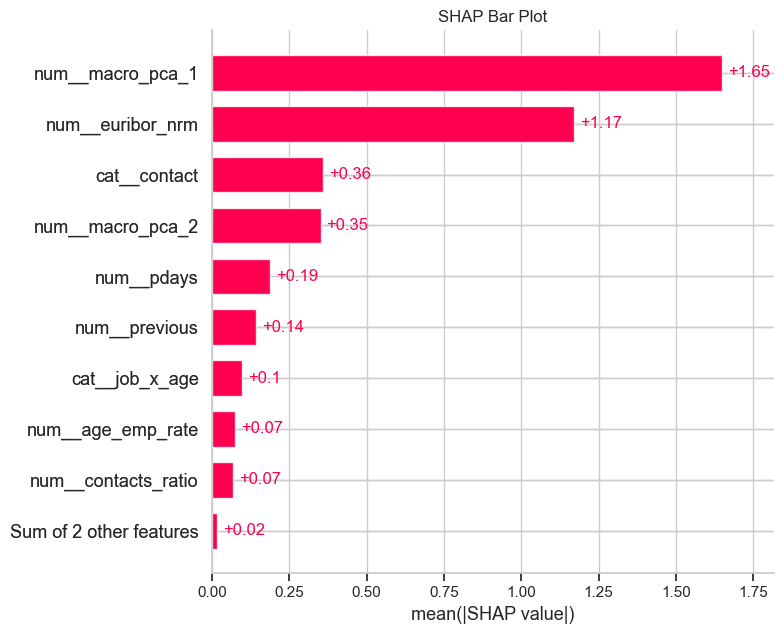

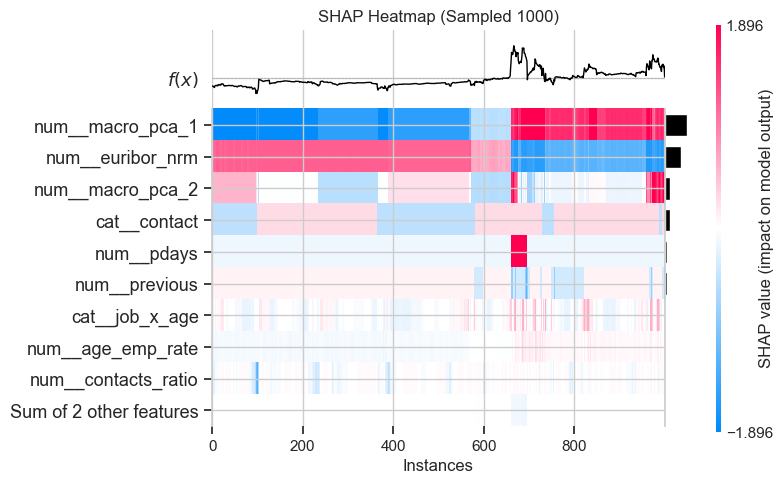

In [18]:
# Extract model and preprocessor
model = clf.named_steps["model"]
preprocessor = clf.named_steps["preprocessor"]

# Transform X_test
X_test_transformed = preprocessor.transform(X_test)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# SHAP Explainer
explainer = shap.LinearExplainer(model, X_test_transformed)
shap_values = explainer.shap_values(X_test_transformed)

# Wrap in dataframe
X_shap = pd.DataFrame(X_test_transformed, columns=feature_names)

# Create SHAP Explanation object
shap_exp = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_shap,
    feature_names=feature_names
)

# Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_exp, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.savefig(f"{path}/summary_plot.png", dpi=300)
plt.show()

# Bar Plot
plt.figure(figsize=(9, 6))
shap.plots.bar(shap_exp, show=False)
plt.title("SHAP Bar Plot")
plt.tight_layout()
plt.savefig(f"{path}/bar_plot.png", dpi=300)
plt.show()

# Heatmap Plot (sampled)
idx = np.random.choice(len(shap_exp), size=1000, replace=False)
shap_exp_sampled = shap_exp[idx]

plt.figure(figsize=(12, 6))
shap.plots.heatmap(shap_exp_sampled, show=False)
plt.title("SHAP Heatmap (Sampled 1000)")
plt.tight_layout()
plt.savefig(f"{path}/heatmap_plot.png", dpi=300)
plt.show()


# Metrics storage and model on gold

In [19]:
# Predict probabilities and classes
y_pred_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

best_parameters = grid.best_params_

# Metrics dictionary
metrics = {
    "AUC": roc_auc_score(y_test, y_pred_proba),
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "LogLoss": log_loss(y_test, y_pred_proba),
    "Best Threshold": best_threshold,
    "Best Parameters": best_parameters,
    "Feature Names": final_feature_names
}


# Save metrics
save_metrics(model_type+"_"+start_date, "logistic_regression", metrics)
save_metrics(model_type, "logistic_regression", metrics)

Metrics saved for logistic_regression → ../97-model_metrics/Logistic_Regression_Model_20251130_182545/logistic_regression_metrics.csv
Metrics saved for logistic_regression → ../97-model_metrics/Logistic_Regression_Model/logistic_regression_metrics.csv


In [20]:
model = ModelWrapper(
    pipeline=clf,
    threshold=best_threshold,
    metadata={
        "model_type": "logistic_regression",
        "AUC": metrics["AUC"],
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"],
        "F1": metrics["F1"],
        "LogLoss": metrics["LogLoss"],
        "notes": "SMOTE + WOE, PCA for macro features, feature selection",
        "Feature Names": final_feature_names
    }
)

model.save(GOLD_PATH + f"/Logistic_Regression_Model_{start_date}.pkl")

Model saved to ../01-data/03-gold//Logistic_Regression_Model_20251130_182545.pkl
